In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from dataclass import *

import torch.nn.functional as F

from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

from utils import calc_psnr

/l/vision/v5/sragas/miniconda3/envs/superres/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def novel_view_synthesis(image_1_1, image_1_2, image_2_1, image_2_2):
    channels, h, w = image_1_1.shape
    canvas = torch.zeros([channels, h*2, w*2], dtype=torch.float)
    
    even_images = [image_1_1, image_1_2]
    odd_images = [image_2_1, image_2_2]
    channels, height, width = canvas.shape
    for h in range(height):
        if h % 2 == 0:
            images = even_images
        else:
            images = odd_images
        for w in range(width):
            if w % 2 == 0:
                image_to_place = images[0]
            else:
                image_to_place = images[1]
            canvas[:, h, w] = image_to_place[:, h//2, w//2]
    del images
    del image_to_place
    return canvas

In [3]:
image_1_1 = torch.ones([3, 2, 2], dtype=torch.float64)
image_1_1[0, :, :] *= 0.1
image_1_1[1, :, :] *= 0.15
image_1_1[2, :, :] *= 0.19
image_1_2 = torch.ones([3, 2, 2], dtype=torch.float64)
image_1_2[0, :, :] *= 0.2
image_1_2[1, :, :] *= 0.25
image_1_2[2, :, :] *= 0.29
image_2_1 = torch.ones([3, 2, 2], dtype=torch.float64)
image_2_1[0, :, :] *= 0.3
image_2_1[1, :, :] *= 0.35
image_2_1[2, :, :] *= 0.39
image_2_2 = torch.ones([3, 2, 2], dtype=torch.float64)
image_2_2[0, :, :] *= 0.4
image_2_2[1, :, :] *= 0.45
image_2_2[2, :, :] *= 0.49

In [4]:
novel_view_synthesis(image_1_1, image_1_2, image_2_1, image_2_2)

tensor([[[0.1000, 0.2000, 0.1000, 0.2000],
         [0.3000, 0.4000, 0.3000, 0.4000],
         [0.1000, 0.2000, 0.1000, 0.2000],
         [0.3000, 0.4000, 0.3000, 0.4000]],

        [[0.1500, 0.2500, 0.1500, 0.2500],
         [0.3500, 0.4500, 0.3500, 0.4500],
         [0.1500, 0.2500, 0.1500, 0.2500],
         [0.3500, 0.4500, 0.3500, 0.4500]],

        [[0.1900, 0.2900, 0.1900, 0.2900],
         [0.3900, 0.4900, 0.3900, 0.4900],
         [0.1900, 0.2900, 0.1900, 0.2900],
         [0.3900, 0.4900, 0.3900, 0.4900]]])

In [5]:
def image_tensor_to_numpy(image_tensor):
    return image_tensor.cpu().detach().numpy().transpose((1,2,0))

In [6]:
train_dataset = PatchedDatasetTensor("./train.csv")
x1, x2, x4, x8, x16 = train_dataset[20]

torch.Size([1, 64, 64])


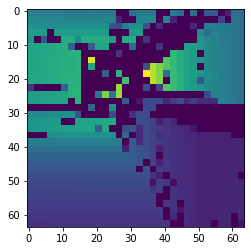

In [7]:
x1_ups = novel_view_synthesis(x1, x1, x1, x1)
print(x1_ups.shape)
plt.imshow(image_tensor_to_numpy(x1_ups))

torch.Size([1, 64, 64])


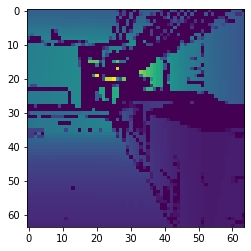

In [8]:
print(x2.shape)
plt.imshow(image_tensor_to_numpy(x2))

torch.Size([1, 128, 128])


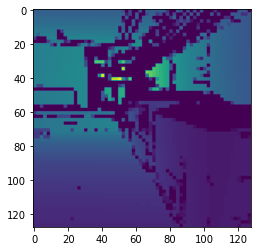

In [9]:
x2_ups = novel_view_synthesis(x2, x2, x2, x2)
print(x2_ups.shape)
plt.imshow(image_tensor_to_numpy(x2_ups))

torch.Size([1, 128, 128])


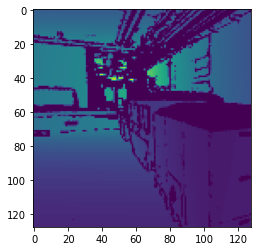

In [10]:
print(x4.shape)
plt.imshow(image_tensor_to_numpy(x4))

In [11]:
def novel_view_synthesis_batch(image_1_1_batch, image_1_2_batch, image_2_1_batch, image_2_2_batch):
    batch_size, channels, height, width = image_1_1_batch.shape
    canvas_batch = torch.zeros([batch_size, channels, height*2, width*2], dtype=torch.float64)
    for batch_idx in range(batch_size):
        image_1_1 = image_1_1_batch[batch_idx]
        image_1_2 = image_1_2_batch[batch_idx]
        image_2_1 = image_2_1_batch[batch_idx]
        image_2_2 = image_2_2_batch[batch_idx]
        
        even_images = [image_1_1, image_1_2]
        odd_images = [image_2_1, image_2_2]
        canvas = novel_view_synthesis(image_1_1, image_1_2, image_2_1, image_2_2)
        canvas_batch[batch_idx, :, :, :] = canvas
    return canvas_batch

In [12]:
def upscale(image_batch, scale_factor):
    batch_size, channels, height, width = image_batch.shape
    upscaled_batch = torch.zeros([batch_size, channels, height*scale_factor, width*scale_factor], dtype=torch.float64)
    for batch_idx in range(batch_size):
        image = tvf.resize(image_batch[batch_idx], (height*scale_factor, width*scale_factor))
        upscaled_batch[batch_idx, :, :, :] = image
    return upscaled_batch

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=4)

In [14]:
for x1_batch, x2_batch, x4_batch, x8_batch, x16_batch in train_dataloader:
    canvas_x1_to_x2 = novel_view_synthesis_batch(x1_batch, x1_batch, x1_batch, x1_batch)
    x1_batch_ups = upscale(x1_batch, 2)
    break

In [15]:
print(x1_batch_ups.shape)
print(canvas_x1_to_x2.shape)

torch.Size([4, 1, 64, 64])
torch.Size([4, 1, 64, 64])


In [16]:
x1_image = x1_batch_ups[3]
canvas_image = canvas_x1_to_x2[3]

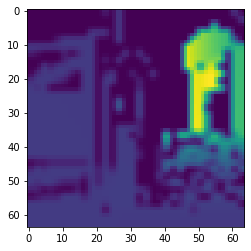

In [17]:
plt.imshow(image_tensor_to_numpy(x1_image))

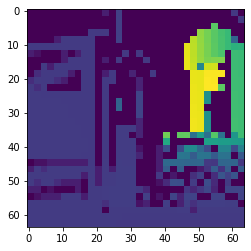

In [18]:
plt.imshow(image_tensor_to_numpy(canvas_image))

In [19]:
print(x1_image.max())
print(canvas_image.max())

tensor(0.9684, dtype=torch.float64)
tensor(0.9686, dtype=torch.float64)


In [20]:
def get_sparse_image_batch(image_batch, position):
        """Takes an image batch and creates a sparse matrix in the following manner:
            P0: [[P0, 0]  P1: [[0, P1]  P2: [[0, 0]  P3: [[0, 0],
                [0, 0]],       [0, 0]],    [P2, 0]],    [0, P3]].

            Args:
                image_batch (torch.Tensor): A batch of image tensors
                position (int): An integer in [0, 1, 2, 3] -> [00, 01, 10, 11], 
                which tells the position of the pixel in the sparse matrix of 2x2.

            Returns:
                torch.Tensor: A batch of image tensors with the sparse matrices.
        """
        batch_size = image_batch.shape[0]
        n_channels = image_batch.shape[1]
        width, height = image_batch.shape[2], image_batch.shape[3]
        offset_x, offset_y = 0, 0
        if position == 1:
            offset_x = 1
        elif position == 2:
            offset_y = 1
        elif position == 3:
            offset_x = offset_y = 1
        indices = [[((j//height)*2) + offset_y, ((j%height)*2) + offset_x] for j in range(width * height)]
        indices = torch.LongTensor(indices)
        # There are 3 channels in the input image. Every row is a flattened channel after this operation.
        flattened_batch = torch.flatten(image_batch, start_dim=2, end_dim=3)
        dest_size =  torch.Size([width*2, height*2])
        result_tensor = torch.rand(batch_size, n_channels, width*2, height*2)
        for batch_idx in range(batch_size):
            for channel_idx in range(n_channels):
                temp_tensor = torch.sparse_coo_tensor(
                    indices.t(), 
                    flattened_batch[batch_idx][channel_idx], 
                    dest_size).to_dense()
                result_tensor[batch_idx][channel_idx] = temp_tensor
        del image_batch
        del indices
        del dest_size
        return result_tensor

In [21]:
def novel_view_synthesis_batch(image_1_1, image_1_2, image_2_1, image_2_2):
        """Creates a novel view synthesis in the following way:
        P0 <- A pixel from image image_1_1, P1 <- A pixel from image image_1_2, 
        P2 <- A pixel from image image_2_1, P3 <- A pixel from image image_2_2
        Arranges them in the following way: 
        [[P0, P1], 
        [P2, P3]]

        Args:
            image_1_1 (torch.Tensor): A batch of images, which should take position P0.
            image_1_2 (torch.Tensor): A batch of images, which should take position P1.
            image_2_1 (torch.Tensor): A batch of images, which should take position P2.
            image_2_2 (torch.Tensor): A batch of images, which should take position P3.

        Returns:
            torch.Tensor: A novel view synthesis image batch which is twice the input image size.
        """
        image_1_1 = get_sparse_image_batch(image_1_1, 0)
        image_1_2 = get_sparse_image_batch(image_1_2, 1)
        image_2_1 = get_sparse_image_batch(image_2_1, 2)
        image_2_2 = get_sparse_image_batch(image_2_2, 3)

        image_temp_1 = torch.add(image_1_1, image_1_2)
        image_temp_2 = torch.add(image_2_1, image_2_2)
        return torch.add(image_temp_1, image_temp_2)

In [22]:
train_dataset = PatchedDatasetTensor("./train_dtu.csv")
train_dataloader = DataLoader(train_dataset, batch_size=4)

In [23]:
for x1_batch, x2_batch, x4_batch, x8_batch, x16_batch in train_dataloader:
    canvas_x1_to_x2 = novel_view_synthesis_batch(x1_batch, x1_batch, x1_batch, x1_batch)
    x2_batch = x2_batch
    break

In [24]:
x2_image = x2_batch[1]
canvas_image = canvas_x1_to_x2[1]

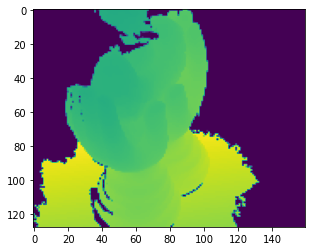

In [25]:
plt.imshow(image_tensor_to_numpy(x2_image))

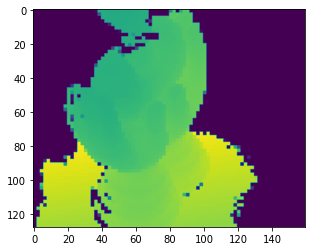

In [26]:
plt.imshow(image_tensor_to_numpy(canvas_image))

In [27]:
batch_idx = 0
for x64_image, x128_image, x256_image, x512_image, _ in train_dataloader:
    x1_image = x64_image[0]
    x2_image = x128_image[0]
    x4_image = x256_image[0]
    x8_image = x512_image[0]
    x16_image = x512_image[1]
    print(x4_image.shape)
    
    x1_image = F.pad(input=x1_image, pad=(280, 280, 224, 224), mode='constant', value=1) # For 64x80
    x2_image = F.pad(input=x2_image, pad=(240, 240, 192, 192), mode='constant', value=1) # For 128x160
    x4_image = F.pad(input=x4_image, pad=(160, 160, 128, 128), mode='constant', value=1) # For 256x320
    
    break
    # example = make_grid([x2_image, x4_image, x8_image, hr_image, hr_image, hr_image], nrow=3)

torch.Size([1, 256, 320])


In [28]:
print(x1_image.shape)
print(x2_image.shape)
print(x4_image.shape)

torch.Size([1, 512, 640])
torch.Size([1, 512, 640])
torch.Size([1, 512, 640])


In [29]:
example = make_grid(
    [x2_image, x2_image, x4_image, x4_image, x8_image, x8_image, x16_image, x1_image], 
    nrow=2)
example.shape

torch.Size([3, 2058, 1286])

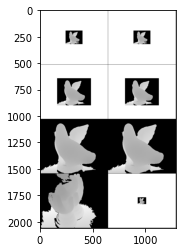

In [30]:
plt.imshow(example.permute(1, 2, 0))